In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cshl_project as cshl
from tqdm.notebook import trange, tqdm

## Random population

- center locations draw from uniform distribution of (25, 25) degrees
- prefered orientation is mapped by 22.5 degree increments and is taken as the test direction
- mask orientation is orthogonal to the test

In [19]:
def randomize_center(n=8, xrange=25, yrange=25, sf=50):
    _x = np.random.rand(n) * xrange / 360 * sf * n
    _y = np.random.rand(n) * xrange / 360 * sf * n
    return _x, _y

In [3]:
def batch_process(v1model, preferred_ori=None, ori_search_step=16):
    if preferred_ori is None:
        _v1_tuning_curve = [cshl.IndexCalc.F1_modulation(v1model.get_response_grating(ori=np.deg2rad(i_ori*(360/ori_search_step)))) for i_ori in range(ori_search_step)] # F1
        _v1_prefered_ori = np.argmax(_v1_tuning_curve) * (360/ori_search_step)
    else:
        _v1_prefered_ori = preferred_ori
        
    _test_resp = v1model.get_response_grating(length=720, ori=np.deg2rad(_v1_prefered_ori))
    _mask_resp = v1model.get_response_grating(length=720, ori=np.deg2rad(_v1_prefered_ori-90))
    _full_resp = [v1model.get_response_plaid(length=720, ori1=np.deg2rad(_v1_prefered_ori), ori2=np.deg2rad(_v1_prefered_ori-90), Δphase=-np.deg2rad(mask_phase_offset)) for mask_phase_offset in range(360)]
    
    return _test_resp, _mask_resp, _full_resp

In [48]:
def _my_indices(v1model, **kwargs):
    _resp_test, _resp_mask, _resp_full = batch_process(v1model, **kwargs)
    _si = cshl.IndexCalc.selectivity_index(cshl.IndexCalc.F1_modulation(_resp_test), cshl.IndexCalc.F1_modulation(_resp_mask))
    _mi = cshl.IndexCalc.F1_modulation([cshl.IndexCalc.masking_index(cshl.IndexCalc.F1_modulation(_resp_test), cshl.IndexCalc.F1_modulation(_resp_mask), cshl.IndexCalc.F1_modulation(item, _resp_test)) for item in _resp_full])
    _pmc = [cshl.IndexCalc.masking_index(cshl.IndexCalc.F1_modulation(_resp_test), cshl.IndexCalc.F1_modulation(_resp_mask), cshl.IndexCalc.F1_modulation(item, order=1)) for item in _resp_full]
    _pmi = cshl.IndexCalc.F1_modulation(_pmc)
    # cshl.IndexCalc.F1_modulation([cshl.IndexCalc.F1_modulation(item, _resp_test) for item in _resp_full])
    return _si, _pmi, _mi

In [66]:
_SI = []
_PMI = []
_MI = []
_v1_pool = []
for _ in trange(1000):
    _v1_model = cshl.V1node([cshl.LGNnode(_center) for _center in zip(*randomize_center(n=8, xrange=25, yrange=25, sf=50))])
    # _v1_model = cshl.V1node([cshl.LGNnode(((_cidx-3.5) * 50 * (0/360), 0)) for _cidx in range(8)])
    _v1_pool.append(_v1_model)
    _si, _pmi, _mi = _my_indices(_v1_model, ori_search_step=180)
    _SI.append(_si)
    _PMI.append(_pmi)
    _MI.append(_mi)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, 'phase modulation amplitude')

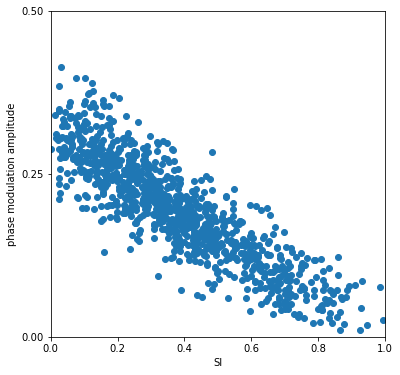

In [62]:
# 25 uniform, 16 step search
plt.figure(figsize=(6, 6))
plt.scatter(_SI, np.array(_PMI))
plt.ylim((0, 0.5))
plt.xlim((0, 1.0))
plt.yticks([0, 0.25, 0.5]);
plt.xlabel("SI")
plt.ylabel("phase modulation amplitude")

(0.0, 1.0)

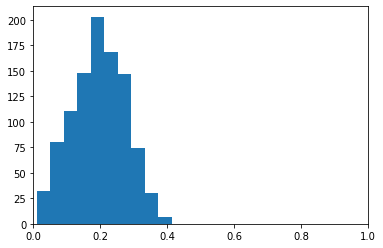

In [65]:
plt.hist(_PMI)
plt.xlim((0, 1))

---

3 	 0.3610443457341638


(-45.0, 45.0)

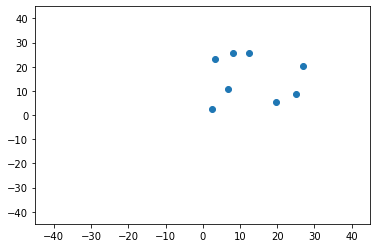

In [50]:
_idx = np.argmax(_PMI)
print(_idx, "\t", _PMI[_idx])
plt.scatter(
    [item.center[0][0] for item in _v1_pool[_idx].subunits],
    [item.center[1][0] for item in _v1_pool[_idx].subunits],
)
plt.xlim((-45, 45)); plt.ylim((-45, 45))

In [ ]:
cshl.IndexCalc.F1_modulation(_pmc)

0.24382898575795464

0.0340991997327407


(-1.0, 1.0)

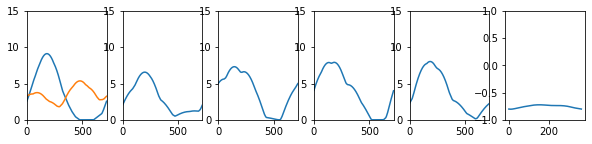

In [51]:
_dev_model = _v1_pool[np.argmin(_PMI)]
# _dev_model = cshl.V1node([cshl.LGNnode(((_cidx-3.5) * 50 * (0/360), 0)) for _cidx in range(8)])
_t_resp, _m_resp, _f_resp = batch_process(_dev_model)
_pmc = [cshl.IndexCalc.masking_index(cshl.IndexCalc.F1_modulation(_t_resp), cshl.IndexCalc.F1_modulation(_m_resp), cshl.IndexCalc.F1_modulation(item, _t_resp, order=1)) for item in _f_resp]
print(cshl.IndexCalc.F1_modulation(_pmc))

fig, axes = plt.subplots(1, 6)
fig.set_size_inches((10, 2))
axes[0].plot(_t_resp)
axes[0].plot(_m_resp)
axes[1].plot(_f_resp[0])
axes[2].plot(_f_resp[89])
axes[3].plot(_f_resp[179])
axes[4].plot(_f_resp[269])
axes[5].plot(_pmc)
for item in axes[:-1]:
    item.set_xlim((0, 720))
    item.set_ylim((0, 15))
    
axes[-1].set_ylim((-1, 1))

In [32]:
_my_indices(cshl.V1node([cshl.LGNnode((np.random.randn()*0, 0)) for _cidx in range(8)]))

(0.0, 0.08338311109761344, 0.06627959037944853)

In [47]:
_my_indices(cshl.V1node([cshl.LGNnode(((_cidx-3.5) * 50 * (45/360), 50)) for _cidx in range(8)]))

(1.0, 0.3124792989532039, 2.2793607310532365e-18)

(0.0, 1.0)

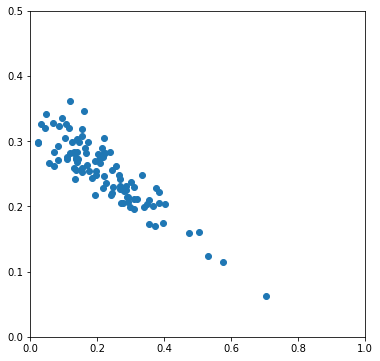

In [52]:
# 12 gaussian, 16 size
plt.figure(figsize=(6, 6))
plt.scatter(_SI, np.array(_PMI))
plt.ylim((0, 0.5))
plt.xlim((0, 1.0))

(0.0, 1.0)

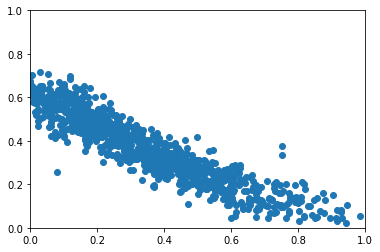

In [134]:
# 12 gaussian, 16 size
plt.scatter(_SI, _ϕ_MI)
plt.ylim((0, 1.0))
plt.xlim((0, 1.0))

(0.0, 1.0)

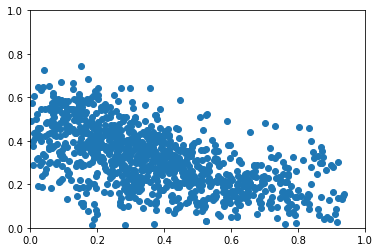

In [128]:
# 12 gaussian
plt.scatter(_SI, _ϕ_MI)
plt.ylim((0, 1.0))
plt.xlim((0, 1.0))

(0.0, 1.0)

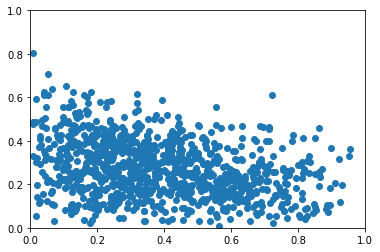

In [126]:
# 25 gaussian
plt.scatter(_SI, _ϕ_MI)
plt.ylim((0, 1.0))
plt.xlim((0, 1.0))

(0.0, 1.0)

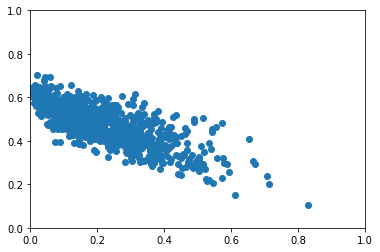

In [123]:
# 25
plt.scatter(_SI, _ϕ_MI)
plt.ylim((0, 1.0))
plt.xlim((0, 1.0))

(0.0, 1.0)

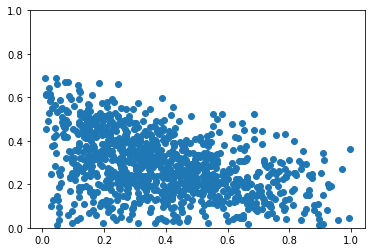

In [120]:
# 45
plt.scatter(_SI, _ϕ_MI)
plt.ylim((0, 1.0))